In [1]:
from pypetri.elements import *
from pypetri.petri_net import *
from pypetri.example_nets import *
import math

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import collections
import random

from tqdm import tqdm
from rltk import rl_utils

In [27]:
class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        # return np.array(state), action, reward, np.array(next_state), done
        return state, action, reward, next_state, done
    
    def size(self):
        return len(self.buffer)
        

In [28]:
class P2P(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(P2P, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.f = f
        self.adj_pt = adj_pt
        self.pm = torch.matmul(self.adj_pt, self.adj_pt.t())
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.matmul(self.pm, x)
        diag = self.pm.diagonal().unsqueeze(0).unsqueeze(2)
        x = x / diag
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
    
class T2T(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu):
        super(T2T, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.f = f
        self.adj_pt = adj_pt
        self.pm = torch.matmul(self.adj_pt.t(), self.adj_pt)
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
    
    def forward(self, x):
        x = torch.matmul(self.pm, x)
        
        diag = self.pm.diagonal()+1
        diag = diag.unsqueeze(0).unsqueeze(2)
        x = x / diag
        x = torch.matmul(x, self.weight.t()) + self.bias.unsqueeze(0)
        
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
    
class T2P(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu, add_bias=True):
        super(T2P, self).__init__()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.add_bias = add_bias
        self.batch_norm = nn.BatchNorm1d(dim_out)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
    def forward(self, x):
        x = torch.matmul(self.adj_pt, x)
        x = torch.matmul(x, self.weight.t())
        if self.add_bias:
            x = x + self.bias.unsqueeze(0)
            
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
            
        x = self.f(x)
        return x
        
class P2T(nn.Module):
    def __init__(self, dim_in, dim_out, adj_pt, f=F.leaky_relu, add_bias=True):
        super(P2T, self).__init__()
        self.adj_pt = adj_pt
        self.f = f
        self.weight = nn.Parameter(torch.Tensor(dim_out, dim_in).float())
        self.bias = nn.Parameter(torch.Tensor(dim_out).float())
        self.add_bias = add_bias
        self.batch_norm = nn.BatchNorm1d(dim_out)
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, x):
        x = torch.matmul(self.adj_pt.t(), x)
        x = torch.matmul(x, self.weight.t())
        if self.add_bias:
            x = x + self.bias.unsqueeze(0)
            
        batch_size, Np, dim_out = x.size()
        x = x.view(-1, dim_out)
        x = self.batch_norm(x)
        x = x.view(batch_size, Np, dim_out) 
        
        x = self.f(x)
        return x
        

In [29]:
class GCPN_layer(torch.nn.Module):
    def __init__(self, lp_in, lt_in, lp_out, lt_out, adj_matrix):
        super(GCPN_layer, self).__init__()
        self.P2P = P2P(lp_in, lp_out, adj_matrix)
        self.T2T = T2T(lt_in, lt_out, adj_matrix)
        self.P2T = P2T(lp_out, lt_out, adj_matrix)
        self.T2P = T2P(lt_out, lp_out, adj_matrix)
        
    def forward(self, p, t):
        p1 = self.P2P(p)
        t1 = self.T2T(t)
        
        dt = self.P2T(p1)
        t2 = t1 + dt
        
        dp = self.T2P(t2)
        p2 = p1 + dp
        
        return p2, t2

In [30]:
class SV_layer(torch.nn.Module):
    def __init__(self, lp_in, lt_in, adj_matrix):
        super(SV_layer, self).__init__()
        self.p_dim = adj_matrix.shape[0]
        self.T2P = T2P(lt_in, lp_in, adj_matrix)
        self.fc = nn.Linear(self.p_dim * lp_in, 1)
        
    def forward(self, p, t):
        dp = self.T2P(t)
        p1 = p+dp
        
        batch_size = p1.size(0)
        
        p1 = p1.view(batch_size, -1)
        out = self.fc(p1)
        return out
        

In [31]:
class AC_layer(torch.nn.Module):
    def __init__(self, lp_in, lt_in, adj_matrix):
        super(AC_layer, self).__init__()
        self.t_dim = adj_matrix.shape[1]
        self.lt_in = lt_in
        self.P2T = P2T(lp_in, lt_in, adj_matrix)
        self.fc = nn.Linear(self.t_dim * lt_in, self.t_dim)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, p, t):
        dt = self.P2T(p)
        t1 = t+dt
        
        batch_size = t1.size(0)
        
        t1 = t1.view(batch_size, self.t_dim * self.lt_in)
        out = self.fc(t1)
        out = F.softmax(out, dim=-1)
        # out = self.softmax(t1)
        # print(p, out)
        return out

In [32]:

class GPNPolicyNet(torch.nn.Module):
    def __init__(self, lp0, lt0, adj_matrix, device):
        super(GPNPolicyNet, self).__init__()
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        
        self.gcpn_1 = GCPN_layer(lp0, lt0, 16, 16, self.adj_matrix)
        self.gcpn_2 = GCPN_layer(16, 16, 32, 32, self.adj_matrix)
        self.gcpn_3 = GCPN_layer(32, 32, 64, 64, self.adj_matrix)
        self.gcpn_4 = GCPN_layer(64, 64, 16, 16, self.adj_matrix)
        self.ac = AC_layer(16, 16, self.adj_matrix)
        

    def forward(self, p, t):
        if isinstance(p, np.ndarray):
            p = torch.from_numpy(p).float()
        if isinstance(t, np.ndarray):
            t = torch.from_numpy(t).float()
        p1, t1 = self.gcpn_1(p, t)
        p2, t2 = self.gcpn_2(p1, t1)
        p3, t3 = self.gcpn_3(p2, t2)
        p4, t4 = self.gcpn_4(p3, t3)
        tf = self.ac(p4, t4)
        # print(tf)
        
        return tf
        

In [33]:
class GPNCriticNet(torch.nn.Module):
    def __init__(self, lp0, lt0, adj_matrix, device):
        super(GPNCriticNet, self).__init__()
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        
        self.gcpn_1 = GCPN_layer(lp0, lt0, 16, 16, self.adj_matrix)
        self.gcpn_2 = GCPN_layer(16, 16, 32, 32, self.adj_matrix)
        self.gcpn_3 = GCPN_layer(32, 32, 64, 64, self.adj_matrix)
        self.sv = SV_layer(64, 64, self.adj_matrix)
        

    def forward(self, p, t):
        if isinstance(p, np.ndarray):
            p = torch.from_numpy(p).float()
        if isinstance(t, np.ndarray):
            t = torch.from_numpy(t).float()
        p1, t1 = self.gcpn_1(p, t)
        p2, t2 = self.gcpn_2(p1, t1)
        p3, t3 = self.gcpn_3(p2, t2)
        out = self.sv(p3, t3)
        # print(out)
        return out

In [ ]:

class PPO:
    def __init__(self, lp, lt, action_dim, adj_matrix, actor_lr, critic_lr, lmbda, epochs, epsilon, ep_decay, eps, gamma, entropy_coef, device):
        self.action_dim = action_dim
        self.adj_matrix = torch.from_numpy(adj_matrix).float().to(device)
        self.actor = GPNPolicyNet(lp, lt, adj_matrix, device).to(device)
        self.critic = GPNCriticNet(lp, lt, adj_matrix, device).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.epsilon = epsilon
        self.ep_decay = ep_decay
        self.eps = eps      # PPO-Clip epsilon
        self.entropy_coef = entropy_coef
        self.device = device

    def take_action(self, state, random_on=True, noise=True, mask=True, debug=False):
        
        orn = False
        if orn and np.random.random() < self.epsilon:
            if self.epsilon > 0.00001:
                self.epsilon *= self.ep_decay
            action = np.random.randint(0, self.action_dim)
            if debug:
                print('random action: ', action)
            return action
        else:
            state_p = state[0]
            state_t = state[1]
            choix = np.where((state_t[:, 0] == 1) & (state_t[:, 1] == 0))[0]
            choix = torch.tensor(choix).to(self.device)
            
            if np.random.random() < self.epsilon and random_on:
                if self.epsilon > 0.001:
                    self.epsilon *= self.ep_decay
                if self.entropy_coef > 0.001:
                    self.entropy_coef *= self.ep_decay
                # print(choix)
                action = choix[np.random.randint(0, len(choix), (1,))].item()
                if debug:
                    print('choix: ', choix)
                    print('inner random action: ', action)
                return action
            
            state_p = torch.tensor([state_p], dtype=torch.float).to(self.device)
            state_t = torch.tensor([state_t], dtype=torch.float).to(self.device)

            probs = self.actor(state_p, state_t)
            # print(probs.shape)
            if noise:
                noise = torch.ones_like(probs) - (torch.rand(probs.size()) * self.epsilon ** 2).to(self.device)
                probs *= noise
                
            if mask:
                mask = torch.zeros_like(probs)
                mask[-1, choix] = 1
                probs = probs * mask
                
            sums= probs.sum(dim=1, keepdim=True)
            if sums == 0:
                if debug:
                    print('sums == 0 !!! ')
                return self.action_dim - 1
            probs = torch.div(probs, sums)
            
            try:
                action_list = torch.distributions.Categorical(probs)
            except:
                # print(self.actor.state_dict())
                print("sums: ", sums)
                print("noise: ", noise)
                print("probs: ", probs)
                print("choix: ", choix)
            
            action = action_list.sample()
            if debug:
                print("sums: ", sums)
                print("noise: ", noise)
                print("choix: ", choix)
                print("probs: ", probs)
                print("action: ", action)
            return action.item()

    def update(self, transition_dict):
        # states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        p_states = [item[0] for item in transition_dict['states']]
        t_states = [item[1] for item in transition_dict['states']]
        
        p_states = torch.tensor(p_states, dtype=torch.float).squeeze(0).to(self.device)
        t_states = torch.tensor(t_states, dtype=torch.float).squeeze(0).to(self.device)
        
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        # next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        next_p_states = [item[0] for item in transition_dict['next_states']]
        next_t_states = [item[1] for item in transition_dict['next_states']]
        
        next_p_states = torch.tensor(p_states, dtype=torch.float).squeeze(0).to(self.device)
        next_t_states = torch.tensor(t_states, dtype=torch.float).squeeze(0).to(self.device)
        
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_p_states, next_t_states) * (1-dones)
        td_delta = td_target - self.critic(p_states, t_states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(p_states, t_states).gather(1, actions) + 1e-10).detach()
        # print(self.critic(p_states, t_states))
        
        for _ in range(self.epochs):
            log_probs = torch.log(self.actor(p_states, t_states).gather(1, actions) + 1e-10)
            
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-self.eps, 1+self.eps)
            entropy = -torch.sum(torch.exp(log_probs) * log_probs, dim=-1).mean()
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            # actor_loss -= self.entropy_coef * entropy
            
            critic_loss = torch.mean(F.mse_loss(self.critic(p_states, t_states), td_target.detach()))

            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            
            
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            # for name, param in self.actor.named_parameters():
            #     if param.grad is not None:
            #         print(f'Parameter: {name}, Gradient norm: {torch.norm(param.grad)}')


In [35]:
# actor_lr = 1.5e-3
# critic_lr = 5e-3
actor_lr = 7e-5
critic_lr = 2e-3
num_episodes = 500
gamma = 0.99
lmbda = 0.99
epochs = 20
epsilon = 0.4      # greedy
ep_decay = 0.98
eps = 0.2
entropy_coef = 0.1

efm_net = EmptyNet('efm_net')
# initial_file_path = 'initial_file/neural_petri_net_lock_seq.csv'
# efm_net.init_by_csv(initial_file_path)
initial_json_path = 'initial_file/N_star_21.json'
efm_net.init_by_json(initial_json_path)
efm_net.set_dt(1)

lp = efm_net.get_state()[0].shape[1]
lt = efm_net.get_state()[1].shape[1]
action_dim = efm_net.get_action_space()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

seed = 17
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
agent = PPO(lp, lt, action_dim, efm_net.get_adj_matrix(), actor_lr, critic_lr, lmbda, epochs, epsilon, ep_decay, eps, gamma, entropy_coef, device)

cuda


In [36]:
print(efm_net.name_node['t30'].target_gesture)
# efm_net.set_reward('fire_time_penalty', -2)

-010


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\87903\AppData\Local\Temp\ipykernel_2288\2545563535.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_p_states = torch.tensor(p_states, dtype=torch.float).squeeze(0).to(self.device)
C:\Users\87903\AppData\Local\Temp\ipykernel_2288\2545563535.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_t_states = torch.tensor(t_states, dtype=torch.float).squeeze(0).to(self.device)
Iteration 3: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it, episode=200, return=54.800, epsilon=0.011]


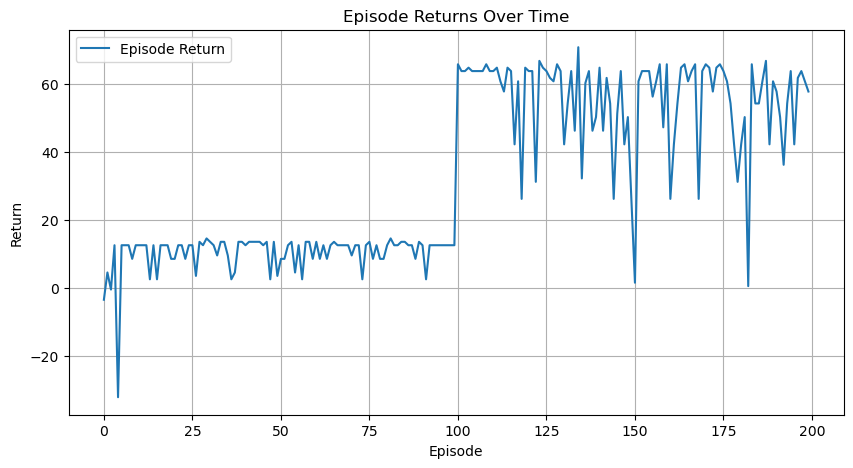

Iteration 7: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it, episode=400, return=40.900, epsilon=0.007]


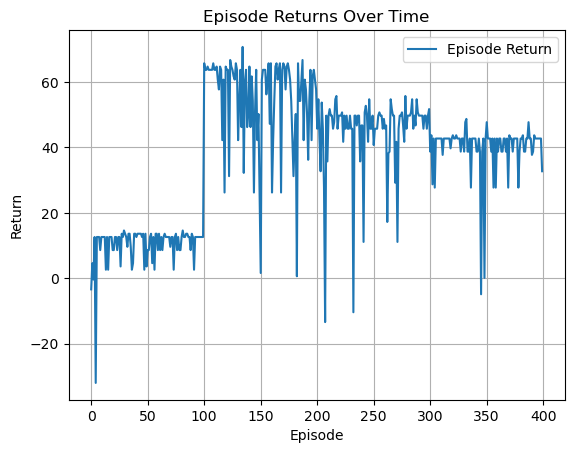

Iteration 11: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it, episode=600, return=70.700, epsilon=0.008]


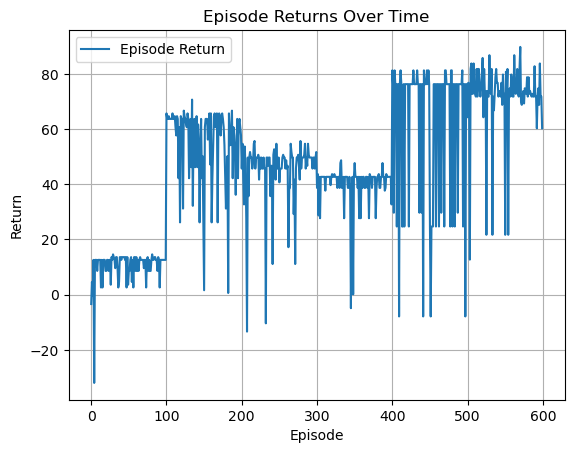

Iteration 15: 100%|██████████| 50/50 [02:07<00:00,  2.55s/it, episode=800, return=61.800, epsilon=0.006]


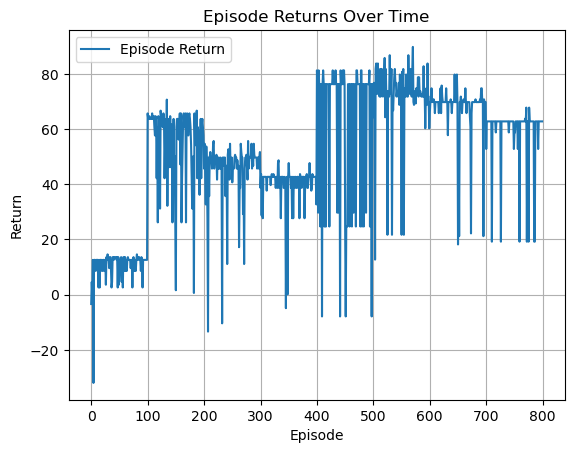

Iteration 19: 100%|██████████| 50/50 [02:07<00:00,  2.54s/it, episode=1000, return=93.030, epsilon=0.006]


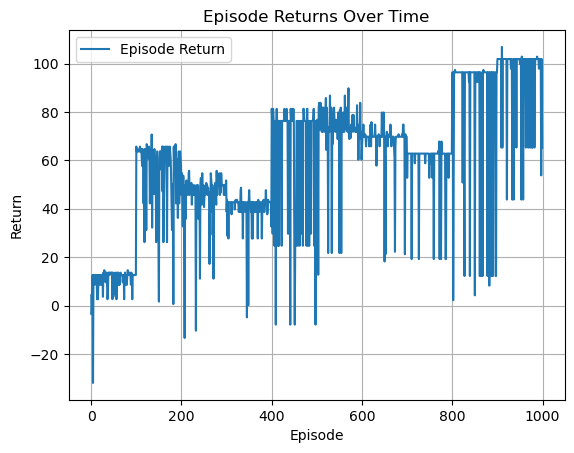

Iteration 23: 100%|██████████| 50/50 [02:12<00:00,  2.66s/it, episode=1200, return=79.240, epsilon=0.004]


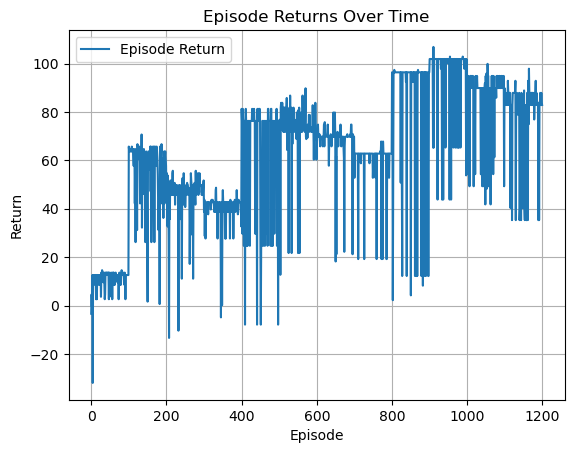

Iteration 27: 100%|██████████| 50/50 [02:22<00:00,  2.86s/it, episode=1400, return=119.240, epsilon=0.004]


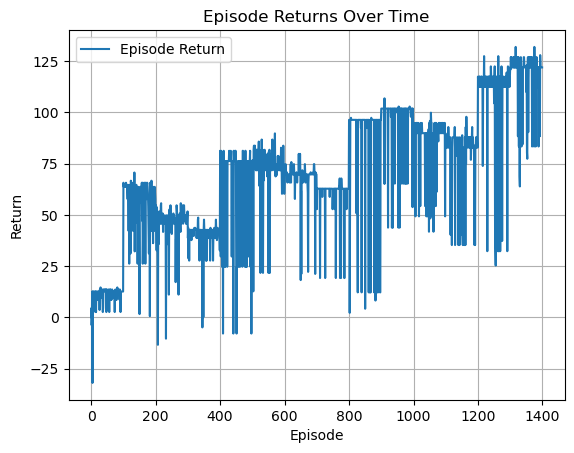

Iteration 31: 100%|██████████| 50/50 [02:31<00:00,  3.04s/it, episode=1600, return=97.780, epsilon=0.004] 


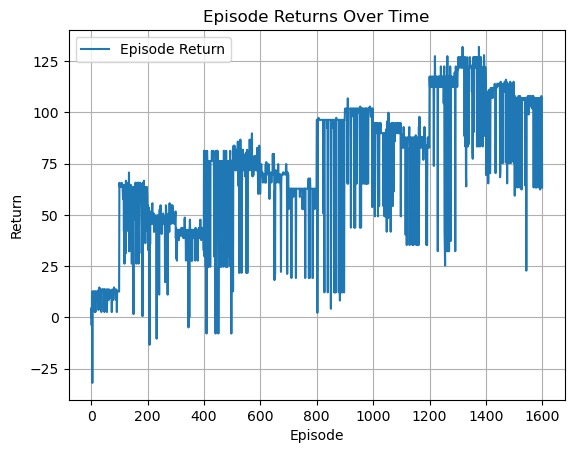

Iteration 35: 100%|██████████| 50/50 [02:40<00:00,  3.21s/it, episode=1800, return=134.440, epsilon=0.004]


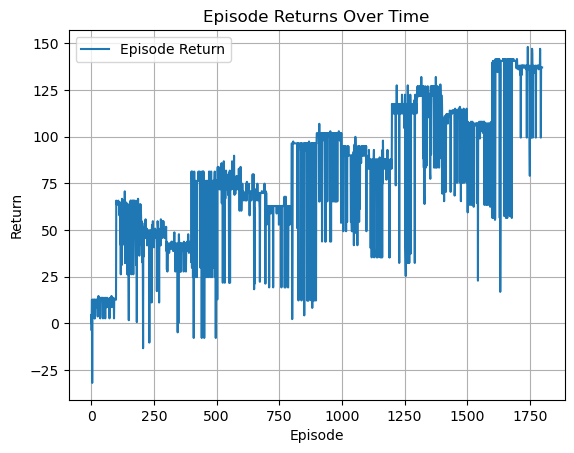

Iteration 39: 100%|██████████| 50/50 [02:50<00:00,  3.42s/it, episode=2000, return=93.120, epsilon=0.004] 


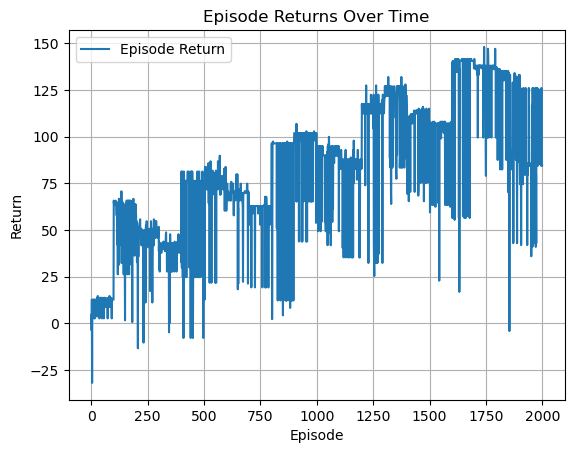

Iteration 43: 100%|██████████| 50/50 [03:00<00:00,  3.61s/it, episode=2200, return=60.200, epsilon=0.003]


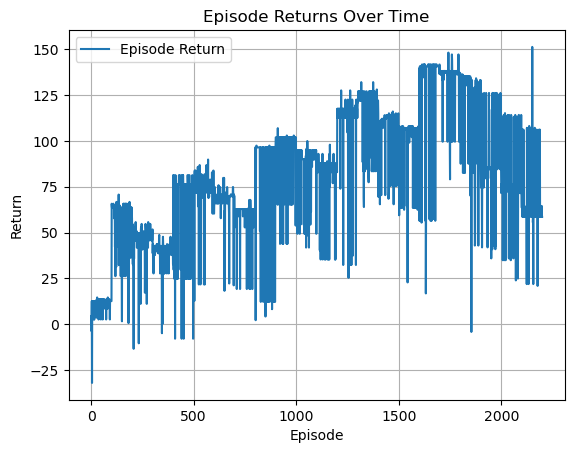

Iteration 47: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it, episode=2400, return=69.420, epsilon=0.004]


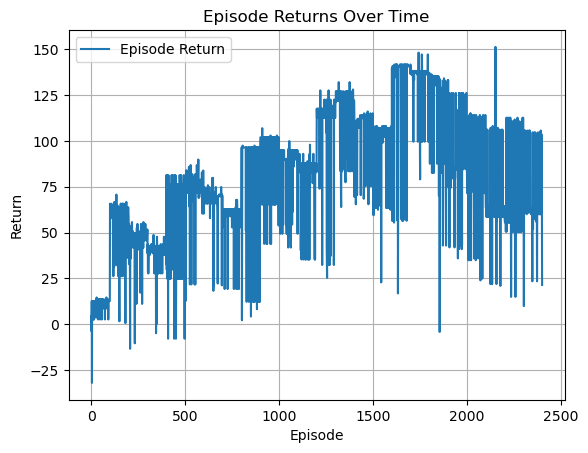

Iteration 51: 100%|██████████| 50/50 [03:17<00:00,  3.95s/it, episode=2600, return=81.470, epsilon=0.003]


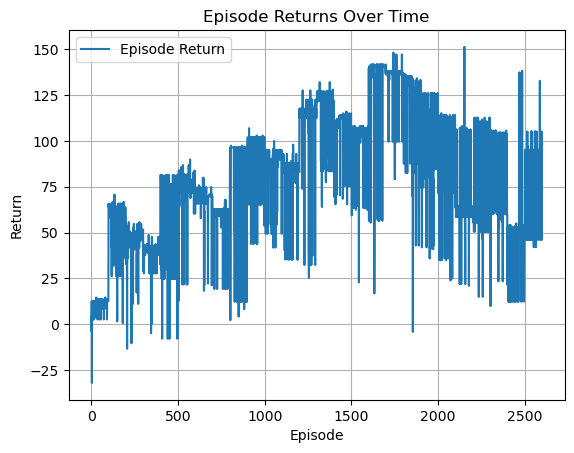

Iteration 55: 100%|██████████| 50/50 [03:36<00:00,  4.32s/it, episode=2800, return=82.500, epsilon=0.003]


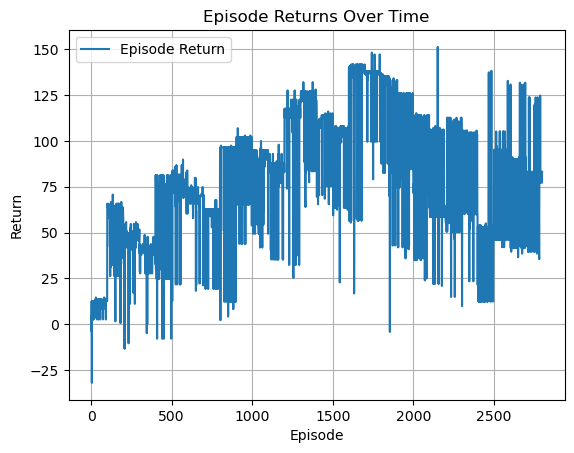

Iteration 59: 100%|██████████| 50/50 [03:34<00:00,  4.29s/it, episode=3000, return=118.050, epsilon=0.003]


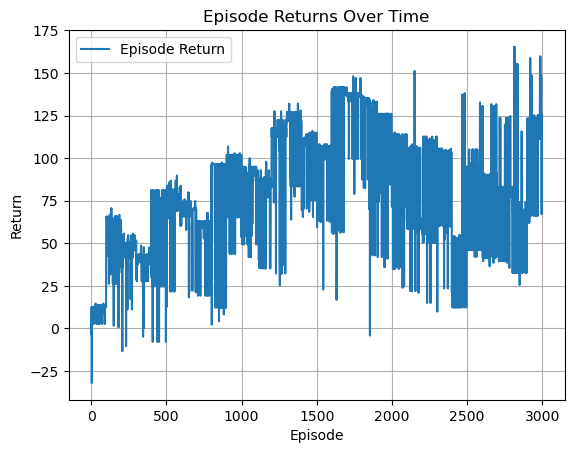

Iteration 63: 100%|██████████| 50/50 [03:42<00:00,  4.45s/it, episode=3200, return=89.620, epsilon=0.003] 


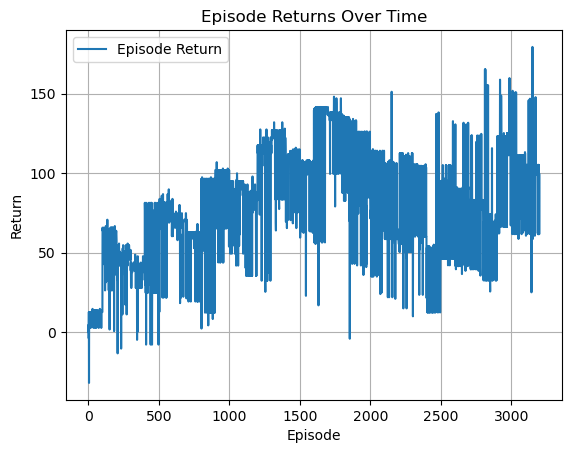

Iteration 67: 100%|██████████| 50/50 [03:54<00:00,  4.70s/it, episode=3400, return=63.640, epsilon=0.002]


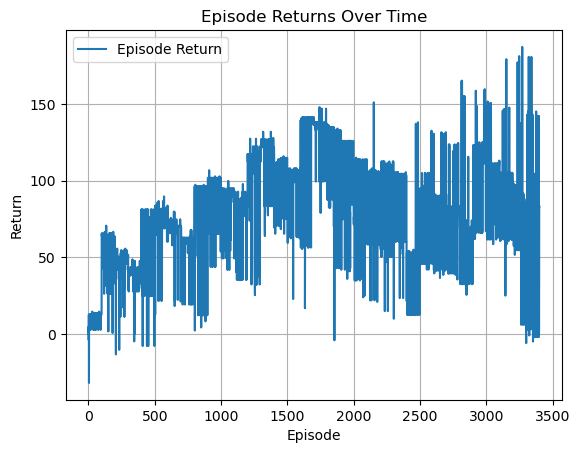

Iteration 71: 100%|██████████| 50/50 [04:02<00:00,  4.85s/it, episode=3600, return=87.660, epsilon=0.002]


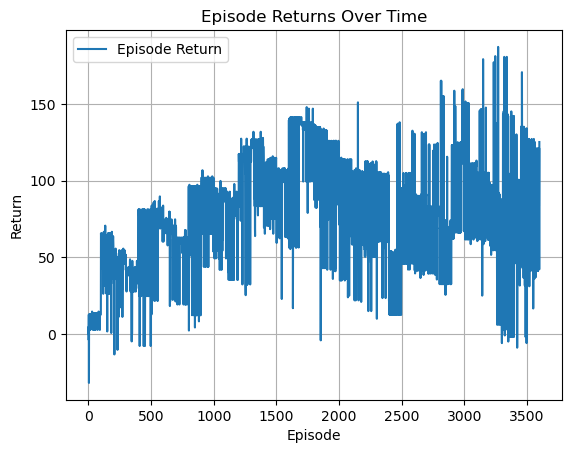

Iteration 75: 100%|██████████| 50/50 [04:07<00:00,  4.96s/it, episode=3800, return=103.180, epsilon=0.002]


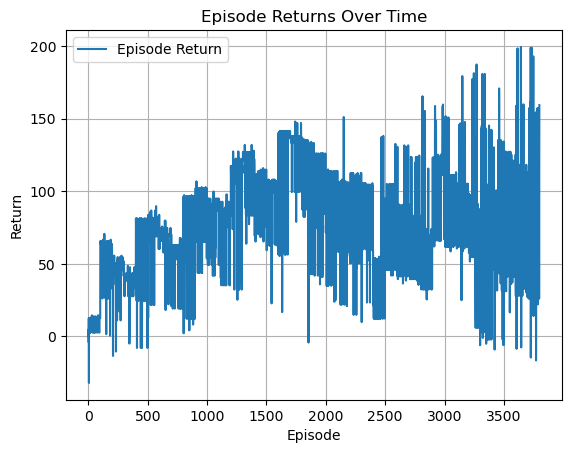

Iteration 79: 100%|██████████| 50/50 [04:18<00:00,  5.16s/it, episode=4000, return=191.500, epsilon=0.002]


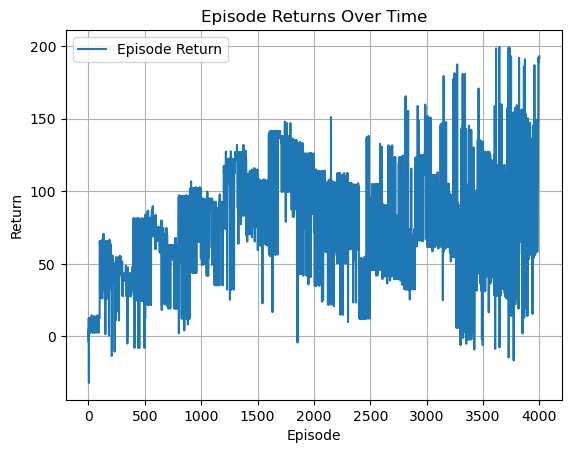

In [37]:
plt.figure(figsize=(10, 5))
plt.title('Episode Returns Over Time')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid(True)

return_list = []
action_list = []
num = 1
for i in range(80):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state = efm_net.reset()
            done = False
            this_action = []
            
            ## sample one sequence
            while not done:
                action = agent.take_action(state)
                this_action.append(action)
                next_state, reward, done = efm_net.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state  
                episode_return += reward

                if efm_net.train_time > 80 + (i//2) * 10:
                    done = True
            
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                                    'return': '%.3f' % np.mean(return_list[-10:]),
                                    'epsilon': '%.3f' % agent.epsilon})
            if (i_episode + 1) % 50 == 0:
                action_list.append(this_action)
                torch.save(agent.actor.state_dict(), f'model/final_21/PPO_actor_21_{num}.pth')
                torch.save(agent.critic.state_dict(), f'model/final_21/PPO_critic_21_{num}.pth')
            pbar.update(1)
            
            
            num += 1
      
    if i % 2 == 0:
        agent.epsilon += 0.2
    
    if (i+1) % 4 == 0:
        
        plt.cla()
        plt.plot(return_list, label='Episode Return')
        plt.title('Episode Returns Over Time')
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.grid(True)
        plt.legend()
        plt.pause(0.1) 

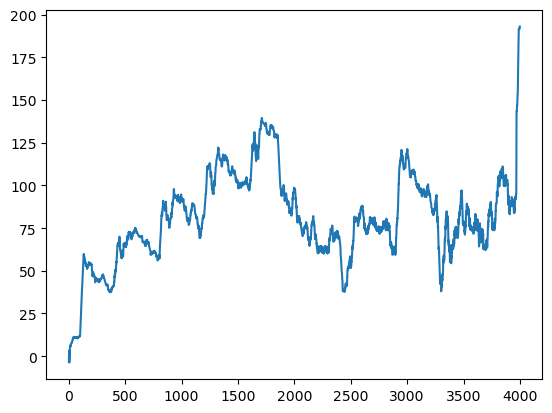

In [38]:
averaged_result = rl_utils.window_average(return_list, 32)
plt.plot(averaged_result)

In [39]:
print(agent.actor.state_dict())

OrderedDict([('gcpn_1.P2P.weight', tensor([[-0.0667,  0.0436,  0.3914],
        [-0.4489, -0.5281,  0.0521],
        [-0.1378,  0.0554, -0.0292],
        [-0.5482, -0.5661, -0.1427],
        [-0.3448, -0.3392, -0.1626],
        [-0.3299, -0.5808, -0.4138],
        [ 0.1253,  0.0832, -0.4601],
        [-0.4678, -0.1364, -0.5521],
        [-0.3578,  0.3230,  0.0684],
        [-0.3901, -0.4418,  0.3774],
        [-0.5619,  0.3569, -0.2858],
        [-0.0305,  0.5331,  0.2270],
        [ 0.3178,  0.2782, -0.0424],
        [-0.2508, -0.3225, -0.2651],
        [ 0.2723, -0.2281, -0.1304],
        [ 0.4683,  0.4523, -0.3404]], device='cuda:0')), ('gcpn_1.P2P.bias', tensor([-0.4321,  0.0880,  0.3838,  0.5401,  0.1491, -0.2538, -0.4253,  0.0030,
         0.3615, -0.3940,  0.3859, -0.3629,  0.4360, -0.3506,  0.3774, -0.3570],
       device='cuda:0')), ('gcpn_1.P2P.batch_norm.weight', tensor([0.9947, 1.0144, 0.9910, 0.9736, 1.0137, 0.9868, 1.0268, 1.0172, 0.9944,
        1.0017, 1.0004, 1.0057, 0

In [40]:
# for i in range(40):
#     with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
#         for i_episode in range(int(num_episodes / 10)):
#             episode_return = 0
#             transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
#             state = efm_net.reset()
#             done = False
#             this_action = []
            
#             ## sample one sequence
#             while not done:
#                 action = agent.take_action(state)
#                 this_action.append(action)
#                 next_state, reward, done = efm_net.step(action)
#                 transition_dict['states'].append(state)
#                 transition_dict['actions'].append(action)
#                 transition_dict['next_states'].append(next_state)
#                 transition_dict['rewards'].append(reward)
#                 transition_dict['dones'].append(done)
#                 state = next_state  
#                 episode_return += reward

#                 if efm_net.train_time > 100:
#                     done = True
            
#             return_list.append(episode_return)
#             agent.update(transition_dict)
#             if (i_episode + 1) % 10 == 0:
#                 pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
#                                     'return': '%.3f' % np.mean(return_list[-10:])})
#                 action_list.append(this_action)
#             pbar.update(1)
    
#     # plt.cla()
#     # plt.plot(return_list, label='Episode Return')
#     # plt.title('Episode Returns Over Time')
#     # plt.xlabel('Episode')
#     # plt.ylabel('Return')
#     # plt.grid(True)
#     # plt.legend()
#     # plt.pause(0.1)        
    
#     if (i+1) % 5 == 0:
#         torch.save(agent.actor.state_dict(), 'model/PPO_actor_lock_s.pth')
#         torch.save(agent.critic.state_dict(), 'model/PPO_critic_lock_s.pth')
#         plt.cla()
#         plt.plot(return_list, label='Episode Return')
#         plt.title('Episode Returns Over Time')
#         plt.xlabel('Episode')
#         plt.ylabel('Return')
#         plt.grid(True)
#         plt.legend()
#         plt.pause(0.1) 

In [41]:
state = efm_net.reset()
action = agent.take_action(state)
print(action)

25


In [42]:
state, reward, done, reward_dict = efm_net.step(action, debug=True)
action = agent.take_action(state)
print(efm_net.last_fire)
print(action, reward_dict, done)

53 {'fire_time_penalty': -0.0, 'fire': 2, 'bonus': 0.0, 'consumption_panelty': -1.0, 'height_cost': -0.0, 'progress': 10.0} False


In [43]:
# total_params = sum(p.numel() for p in agent.actor.gcpn_3.P2T.parameters())

# print(f"Total parameters: {total_params}")

In [44]:
import csv

result_path = 'train_results/final/return_doc_21.csv'

with open(result_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(return_list)
    
action_path = 'train_results/final/action_doc_21.csv'

with open(action_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(action_list)

In [45]:
probe = -1
# print(action_list[probe])
for a in action_list[probe]:
    if a != 53:
        print(a+1)
    else:
        print("--")

26
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
--
--
--
--
--
--
52
27
--
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
52
1
--
--
--
--
--
--
--
--
--
--
28
--
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
29
52
--
--
--
--
--
--
--
--
--
2
--
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
52
3
--
--
--
--
--
--
--
--
--
--
30
--
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
52
4
--
--
--
--
--
--
--
--
--
--
31
--
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
52
5
--
--
--
--
--
--
--
--
--
--
32
--
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
52
33
--
--
--
--
--
--
--
--
--
--
6
--
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
7
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
--
--
--
--
--
--
34
52
--
--
--
--
--
--
--
--
--
51
--
--
--
--
--
--
--
--
--
--
53
--
--
--
--
52
8
--
--
--
--
--
--
--


In [46]:
efm_net.reset()
for i in range(len(action_list[probe])):
# for i in range(2):
    # p_state = efm_net.get_state()[0]
    # p_dist = np.sum(np.abs(p_state[:, 1] - p_state[:, 0]) * p_state[:, 2])
    # print(p_dist, p_state)
    next_state, reward, done, reward_dict = efm_net.step(action_list[probe][i], debug=True)
    
    # print(efm_net.train_time, action_list[i], reward_dict, next_state)
    print(action_list[probe][i]+1, reward, reward_dict)

26 11.0 {'fire_time_penalty': -0.0, 'fire': 2, 'bonus': 0.0, 'consumption_panelty': -1.0, 'height_cost': -0.0, 'progress': 10.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -5.0 {'fire_time_penalty': -0.0, 'idle': -5, 'progress': 0.0}
53 6.0 {'fire_time_penalty': -0.0, 'fire': 2, 'bonus': 5.0, 'consumption_panelty': -1.0, 'height_cost': -0.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progress': 0.0}
54 -1.0 {'fire_time_penalty': -1.0, 'progre

In [47]:
efm_net.reset()

[array([[0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [0., 1., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1

In [48]:
next_state, reward, done, reward_dict = efm_net.step(25, debug=True)

# state_p = next_state[0]
# state_t = next_state[1]
# choix = np.where((state_t[:, 0] == 1) & (state_t[:, 1] == 0))[0]
# choix = torch.tensor(choix).to(agent.device)

# state_p = torch.tensor([state_p], dtype=torch.float).to(agent.device)
# state_t = torch.tensor([state_t], dtype=torch.float).to(agent.device)

# probs = agent.actor(state_p, state_t)
# mask = torch.zeros_like(probs)
# mask[-1, choix] = 1
# probs = probs * mask 
# print(choix, probs)
print(agent.take_action(next_state, debug=True))
print(reward, reward_dict, efm_net.current_gesture)
print(efm_net.ready_transition)

sums:  tensor([[2.6035e-39]], device='cuda:0', grad_fn=<SumBackward1>)
noise:  tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')
choix:  tensor([53], device='cuda:0')
probs:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       device='cuda:0', grad_fn=<DivBackward0>)
action:  tensor([53], device='cuda:0')
53
11.0 {'fire_time_penalty': -

In [49]:
for p in efm_net.places.values():
    print(p.name, p.tokens)

p01 0
p02 0
p03 0
p04 0
p05 0
p06 0
p07 0
p08 0
p09 0
p10 0
p11 0
p12 0
p13 0
p14 0
p15 0
p16 0
p17 0
p18 0
p19 0
p20 0
p21 0
p22 0
p23 0
p24 0
p25 0
p26 0
p27 1
p28 1
p29 1
p30 1
p31 1
p32 1
p33 1
p34 1
p35 1
p36 1
p37 1
p38 1
p39 1
p40 1
p41 1
p42 1
p43 1
p44 1
p45 1
p46 1
p47 1
p48 1
p49 1
p50 1
p51 0
p52 0
p53 0
p54 0
p55 1
p56 0
p57 1
p58 0
l01 1
l02 0
l03 0
l04 0
l05 0
l06 0
l07 0
l08 0
l09 0
l10 0
l11 0
l12 0
l13 0
l14 0
l15 0
l16 0
l17 0
l18 0
l19 0
l20 0
l21 0
l22 0
l23 0
l24 0
l25 0
l26 0
l27 0
l28 0
l29 0
l30 0
l31 0
l32 0
l33 0
l34 0
l35 0
l36 0
l37 0
l38 0
l39 0
l40 0
l41 0
l42 0
l43 0
l44 0
l45 0
l46 0
l47 0
l48 0
l49 0
l50 0


In [50]:
for t in efm_net.transitions.values():
    print(t.name, t.target_gesture, t.is_same_gesture('0001'))

t01 -100 False
t02 -100 False
t03 -100 False
t04 -100 False
t05 -100 False
t06 -100 False
t07 -100 False
t08 -100 False
t09 -100 False
t10 -100 False
t11 -100 False
t12 -100 False
t13 -100 False
t14 -100 False
t15 -100 False
t16 -100 False
t17 -100 False
t18 -100 False
t19 -100 False
t20 -100 False
t21 -100 False
t22 -100 False
t23 -100 False
t24 -100 False
t25 -100 False
t26 -010 False
t27 -010 False
t28 -010 False
t29 -010 False
t30 -010 False
t31 -010 False
t32 -010 False
t33 -010 False
t34 -010 False
t35 -010 False
t36 -010 False
t37 -010 False
t38 -010 False
t39 -010 False
t40 -010 False
t41 -010 False
t42 -010 False
t43 -010 False
t44 -010 False
t45 -010 False
t46 -010 False
t47 -010 False
t48 -010 False
t49 -010 False
t50 -010 False
t51 -001 True
t52 ---- True
t53 -001 True
